In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
file_path = "/kaggle/input/article-dataset-2/bbc-text-1.csv"
df = pd.read_csv(file_path)

In [3]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

num_topics = 5
nmf_model = NMF(n_components = num_topics, random_state = 42)
nmf_topics = nmf_model.fit_transform(tfidf_matrix)

In [4]:
feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics(model, feature_names, num_words = 10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_features
    return pd.DataFrame(topics)

topic_words = display_topics(nmf_model, feature_names)

In [5]:
print(topic_words)

      Topic 1     Topic 2  Topic 3   Topic 4   Topic 5
0      mobile          mr  england      film    growth
1      people      labour     game      best   economy
2       music       blair      win    awards      said
3        said    election    wales     award      bank
4     digital       brown  ireland     actor      year
5  technology       party      cup     oscar     sales
6       phone        said     said   actress  economic
7       users  government     team  festival       oil
8   broadband      howard     play       won    prices
9    software    minister  players     films      2004


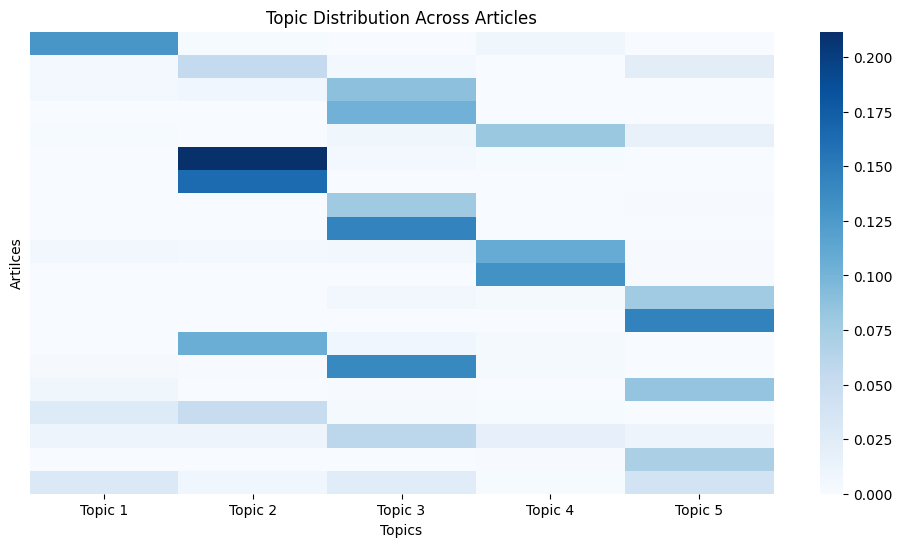

In [6]:
import seaborn as sns

num_articles = 20
topic_df = pd.DataFrame(nmf_topics[:num_articles], columns=[f"Topic {i+1}" for i in range(num_topics)])

plt.figure(figsize=(12, 6))
sns.heatmap(topic_df, annot=False, cmap="Blues", xticklabels=True, yticklabels=False)
plt.xlabel("Topics")
plt.ylabel("Artilces")
plt.title("Topic Distribution Across Articles")
plt.show()

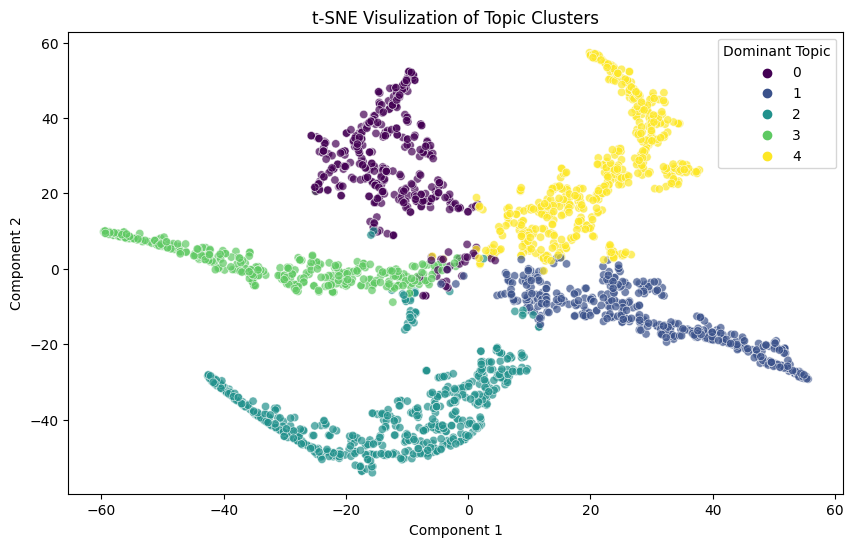

In [7]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=42)
tsne_results = tsne_model.fit_transform(nmf_topics)

tsne_df = pd.DataFrame(tsne_results, columns=["Component 1", "Component 2"])
tsne_df["Dominant Topic"] = nmf_topics.argmax(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="Dominant Topic", palette="viridis", data=tsne_df, alpha=0.7)
plt.title("t-SNE Visulization of Topic Clusters")
plt.show()

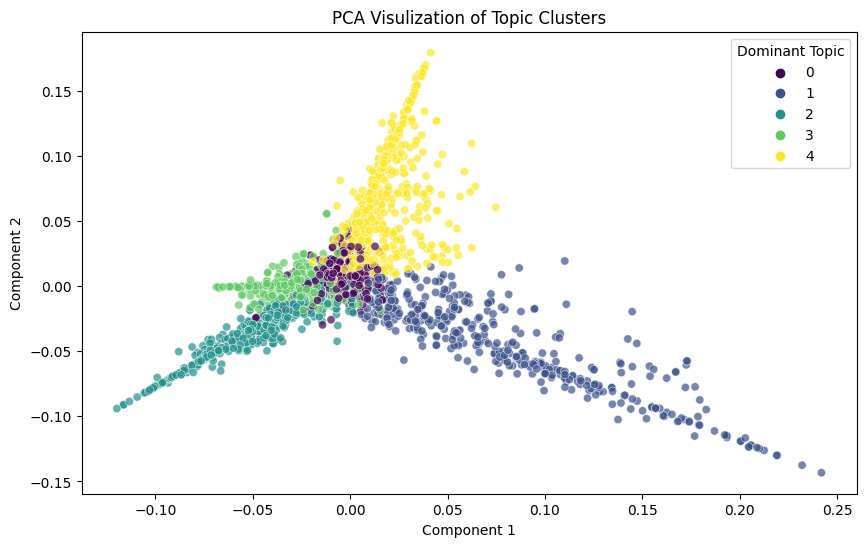

In [8]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2, random_state=42)
pca_results = pca_model.fit_transform(nmf_topics)

pca_df = pd.DataFrame(pca_results, columns=["Component 1", "Component 2"]) 
pca_df["Dominant Topic"] = nmf_topics.argmax(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(x="Component 1", y="Component 2", hue="Dominant Topic", palette="viridis", data=pca_df, alpha=0.7)
plt.title("PCA Visulization of Topic Clusters")
plt.show()

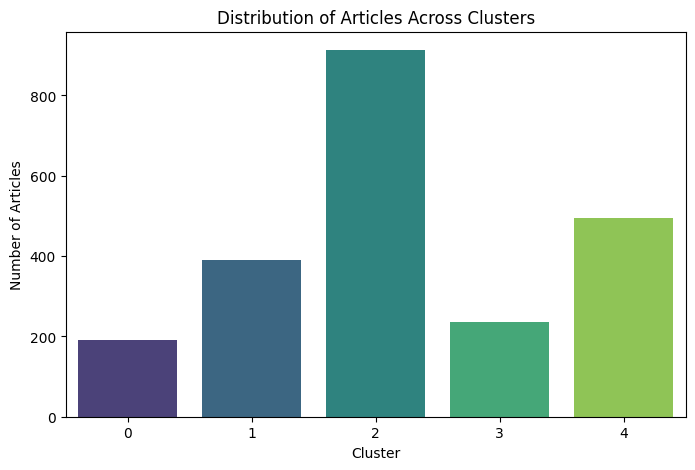

In [9]:
from sklearn.cluster import KMeans

num_clusters = 5
Kmeans_model = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = Kmeans_model.fit_predict(nmf_topics)

df["Cluster"] = clusters

cluster_counts = df["Cluster"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values,  palette="viridis")
plt.xlabel("Cluster")
plt.ylabel("Number of Articles")
plt.title("Distribution of Articles Across Clusters")
plt.show()

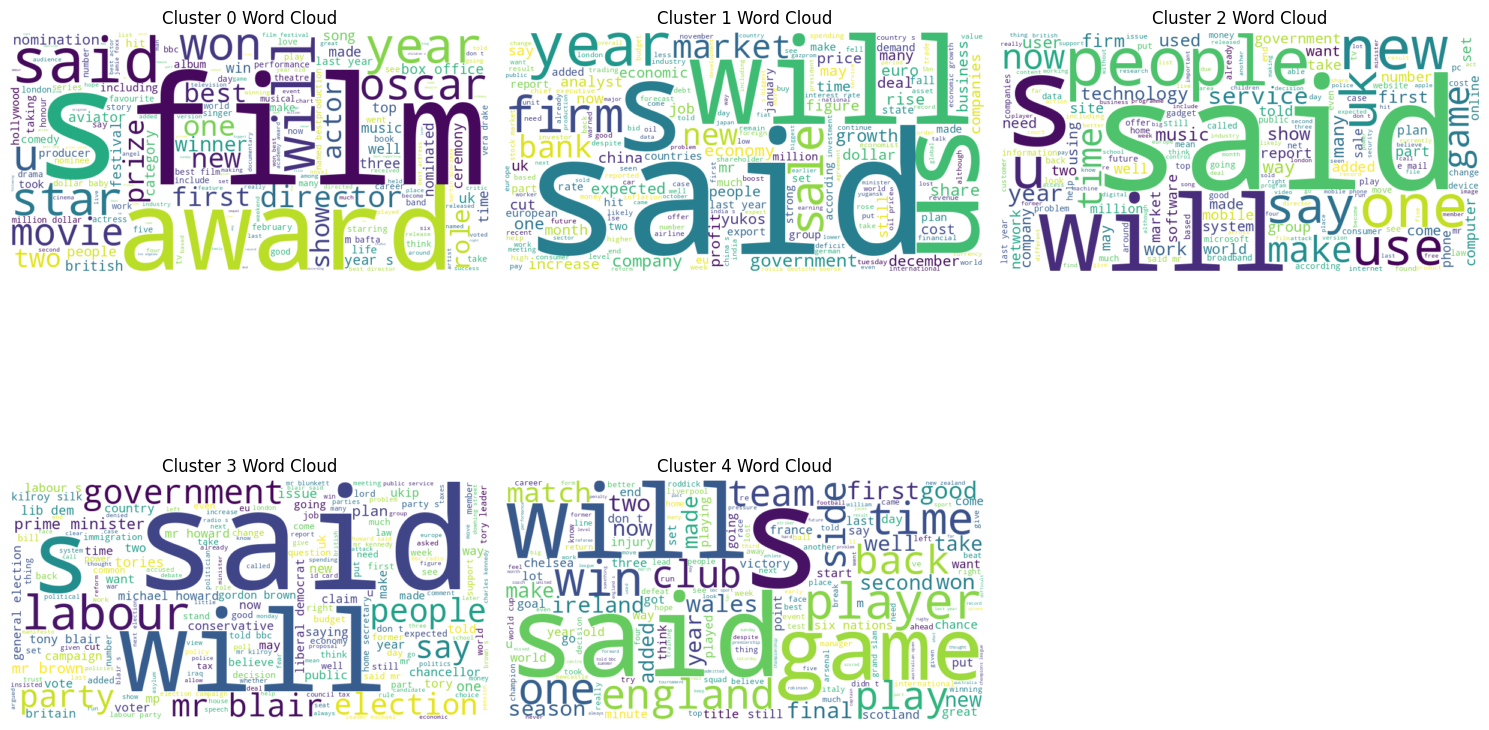

In [10]:
from wordcloud import WordCloud

plt.figure(figsize=(15, 10))
for i in range(num_clusters):
    cluster_text = " ".join(df[df["Cluster"] == i]["text"])
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_text)
    plt.subplot(2, 3, i + 1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {i} Word Cloud")
plt.tight_layout()
plt.show()


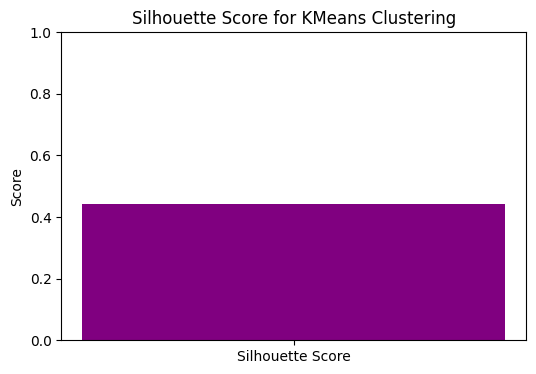

In [11]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(nmf_topics, clusters)

plt.figure(figsize=(6, 4))
plt.bar(["Silhouette Score"], [silhouette_avg], color="purple")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Silhouette Score for KMeans Clustering")
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(nmf_topics, df["Cluster"], test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,36.000000
1,0.965116,1.000000,0.982249,83.000000
2,0.978022,0.978022,0.978022,182.000000
3,1.000000,1.000000,1.000000,50.000000
4,0.989011,0.957447,0.972973,94.000000
accuracy,0.982022,0.982022,0.982022,0.982022
macro avg,0.986430,0.987094,0.986649,445.000000
weighted avg,0.982184,0.982022,0.981991,445.000000


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

label_encoder = LabelEncoder()
df["Sentiment_Label"] = label_encoder.fit_transform(df["Cluster"])

X_train, X_test, y_train, y_test = train_test_split(nmf_topics, df["Sentiment_Label"], test_size=0.2, random_state=42)

logreg_model = make_pipeline(LogisticRegression(max_iter=200, random_state=42))
logreg_model.fit(X_train, y_train)

y_pred = logreg_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
0,1.000000,0.472222,0.641509,36.0
1,1.000000,0.602410,0.751880,83.0
2,0.671587,1.000000,0.803532,182.0
3,1.000000,0.520000,0.684211,50.0
4,1.000000,0.861702,0.925714,94.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.934317,0.691267,0.761369,445.0
weighted avg,0.865683,0.800000,0.793193,445.0
